In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['simhei']
import seaborn as sns
%matplotlib inline

In [49]:
pdd = pd.read_csv('拼多多优惠券数据.csv')

In [4]:
pdd.info()   # job、marital、returned、loan为类别变量，后期用one-hot编码
             # ID这一列没用，后期删掉
             # 无缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25317 entries, 0 to 25316
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          25317 non-null  int64 
 1   age                         25317 non-null  int64 
 2   job                         25317 non-null  object
 3   marital                     25317 non-null  object
 4   default                     25317 non-null  object
 5   returned                    25317 non-null  object
 6   loan                        25317 non-null  object
 7   coupon_used_in_last6_month  25317 non-null  int64 
 8   coupon_used_in_last_month   25317 non-null  int64 
 9   coupon_ind                  25317 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.9+ MB


In [5]:
pdd.head()

,ID,age,job,marital,default,returned,loan,coupon_used_in_last6_month,coupon_used_in_last_month,coupon_ind
0,1,43,management,married,no,yes,no,2,0,0
1,2,42,technician,divorced,no,yes,no,1,1,0
2,3,47,admin.,married,no,yes,yes,2,0,0
3,4,28,management,single,no,yes,yes,2,0,0
4,5,42,technician,divorced,no,yes,no,5,0,0


In [9]:
pdd.describe() # 年龄最大值为95岁，可能存在异常值
               # coupon_used_in_last6_month分布较为离散，后期采用分箱

,ID,age,coupon_used_in_last6_month,coupon_used_in_last_month,coupon_ind
count,25317.000000,25317.000000,25317.000000,25317.000000,25317.000000
mean,12659.000000,40.935379,2.772050,0.292847,0.116957
std,7308.532719,10.634289,3.136097,0.765498,0.321375
min,1.000000,18.000000,1.000000,0.000000,0.000000
25%,6330.000000,33.000000,1.000000,0.000000,0.000000
50%,12659.000000,39.000000,2.000000,0.000000,0.000000
75%,18988.000000,48.000000,3.000000,0.000000,0.000000
max,25317.000000,95.000000,55.000000,15.000000,1.000000


EDA以及数据清洗

In [14]:
pdd['coupon_ind'].value_counts(1)    # 优惠券使用与未使用的数据不平衡，后期使用改变权重的方法

0    0.883043
1    0.116957
Name: coupon_ind, dtype: float64

In [43]:
tmp = pd.DataFrame(pdd['coupon_ind'].value_counts(1)).reset_index().rename(columns = {'index':'flag','coupon_ind':'rate'})
tmp

,flag,rate
0,0,0.883043
1,1,0.116957


<AxesSubplot: xlabel='flag', ylabel='rate'>

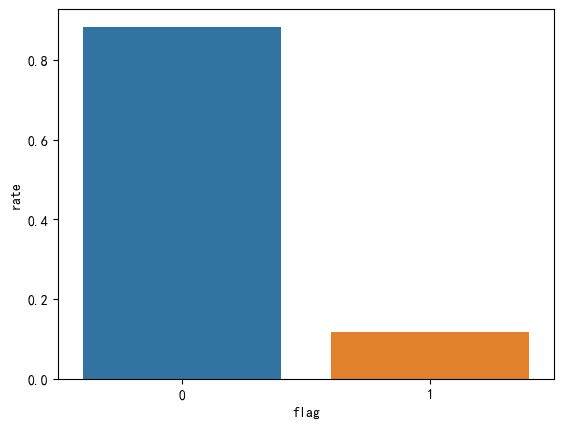

In [45]:
sns.barplot(x = 'flag',y = 'rate',data = tmp)

年龄分布情况

In [13]:
pdd['age'].describe()

import warnings
warnings.filterwarnings('ignore')

<AxesSubplot: xlabel='age', ylabel='Density'>

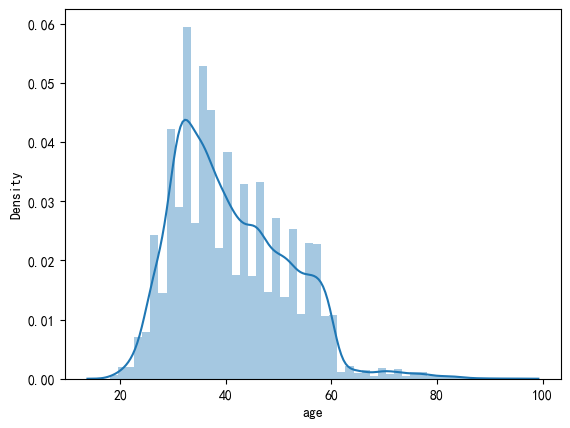

In [51]:
sns.distplot(pdd['age'])  # 年龄分布主要在20-60之间
                          # 大于60岁的可能是异常值，要去除

<AxesSubplot: ylabel='age'>

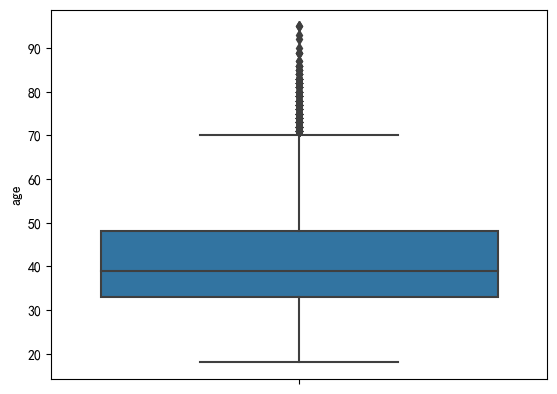

In [52]:
sns.boxplot(y = 'age',data = pdd)

# 规定大于75%+四分位差的1.5倍为异常值

In [65]:
newmax = pdd['age'].describe()['75%']+ 1.5*(pdd['age'].describe()['75%']-pdd['age'].describe()['25%'])
print(newmax)
pdd[pdd['age']>newmax]['age'].count()  # pdd[pdd['age']>newmax] 输出的是大于这个条件的df，再在age里面count一下

70.5


284

In [66]:
# 去除异常值
pdd = pdd[pdd['age']<= newmax]

In [72]:
# 查看年龄与是否用优惠券的关系
pdd.groupby('coupon_ind')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
coupon_ind,,,,,,,,
0,22202.0,40.569859,9.751967,18.0,33.0,39.0,48.0,70.0
1,2831.0,40.207700,11.526063,18.0,31.0,37.0,49.0,70.0


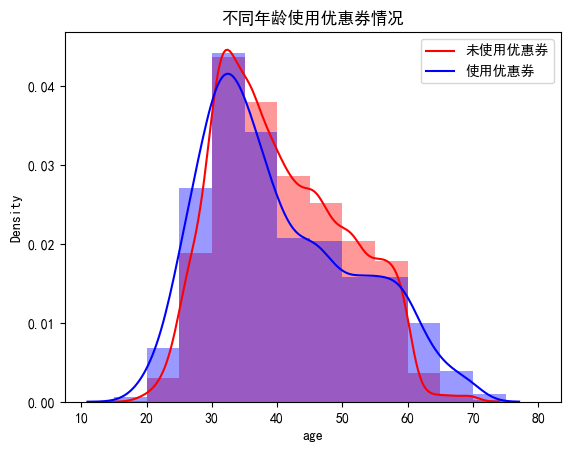

In [80]:
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
sns.distplot(pdd[pdd['coupon_ind']==0]['age'],bins = bins,color = 'red')
sns.distplot(pdd[pdd['coupon_ind']==1]['age'],bins = bins,color = 'blue')
plt.title('不同年龄使用优惠券情况')
plt.legend(['未使用优惠券','使用优惠券'])

使用拼多多的用户年龄主要分布在20-70之间
小于35以及大于60岁的用户更倾向于使用优惠券，35-60之间的用户倾向于不使用
分析：
小于35岁的用户因为较为年轻，对于APP的使用较为熟悉，更容易掌握优惠券的用法，大于60岁的用户可能不熟悉APP的使用，所以较为少用优惠券。
35-60岁之间的用户一方面可以由于APP推出的相关活动并不熟悉，另外可能是经济能力较好而无须费心使用优惠券。

过去六个月的优惠券使用情况

In [81]:
pdd['coupon_used_in_last6_month'].describe()

count    25033.000000
mean         2.779171
std          3.146620
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         55.000000
Name: coupon_used_in_last6_month, dtype: float64

Text(0.5, 1.0, '过去六个月优惠券使用情况')

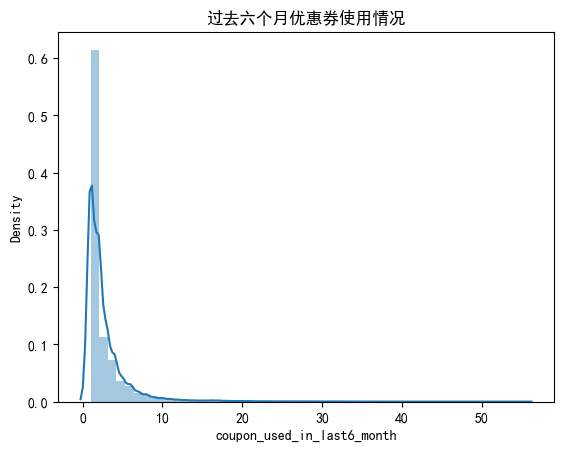

In [83]:
sns.distplot(pdd['coupon_used_in_last6_month'])
plt.title('过去六个月优惠券使用情况')

过去一个月的优惠券使用情况

In [84]:
pdd['coupon_used_in_last_month'].describe()

count    25033.000000
mean         0.289498
std          0.763161
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: coupon_used_in_last_month, dtype: float64

Text(0.5, 1.0, '过去1个月优惠券使用情况分布')

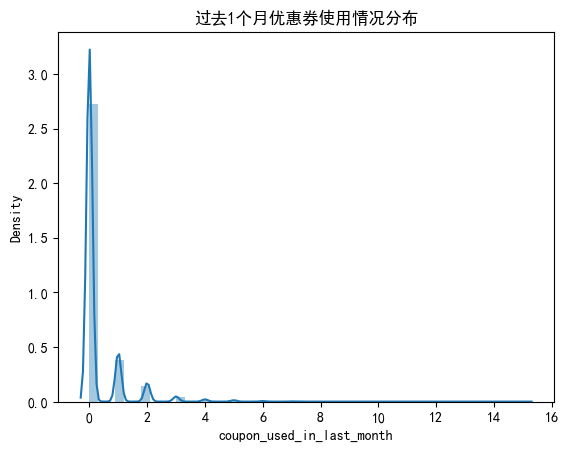

In [86]:
sns.distplot(pdd['coupon_used_in_last_month'])
plt.title('过去1个月优惠券使用情况分布')

In [102]:
pdd['job'].value_counts()

blue-collar      5455
management       5287
technician       4239
admin.           2906
services         2342
retired          1026
self-employed     881
entrepreneur      855
unemployed        701
housemaid         650
student           533
unknown           158
Name: job, dtype: int64

Text(0.5, 1.0, '各个职业的用户数量')

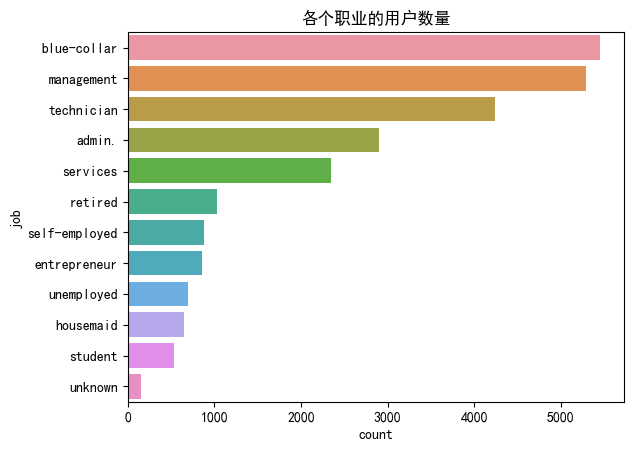

In [104]:
sns.countplot(y='job',data = pdd,order =pdd['job'].value_counts().sort_values(ascending = False).index)
plt.title('各个职业的用户数量')

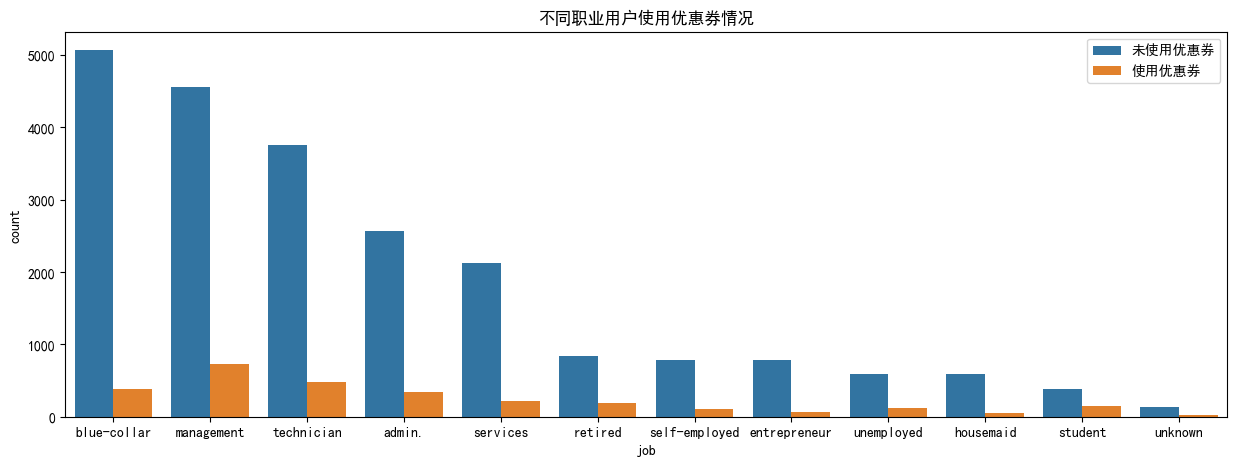

In [108]:
plt.figure(figsize = (15,5))
sns.countplot(x='job',hue = 'coupon_ind',data = pdd,order =pdd['job'].value_counts().sort_values(ascending = False).index)
plt.title('不同职业用户使用优惠券情况')
plt.legend(['未使用优惠券','使用优惠券'])

In [223]:
tmp = pd.DataFrame(pdd.groupby('job')['coupon_ind'].value_counts(1)).rename(columns = {'coupon_ind':'rate'}).reset_index()
tmp[tmp['coupon_ind'] == 1].sort_values(by = 'rate',ascending = False)

,job,coupon_ind,rate
17,student,1,0.268293
11,retired,1,0.178363
21,unemployed,1,0.162625
9,management,1,0.138453
1,admin.,1,0.116999
13,self-employed,1,0.116913
23,unknown,1,0.113924
19,technician,1,0.113234
15,services,1,0.090094
7,housemaid,1,0.081538


<AxesSubplot: xlabel='rate', ylabel='job'>

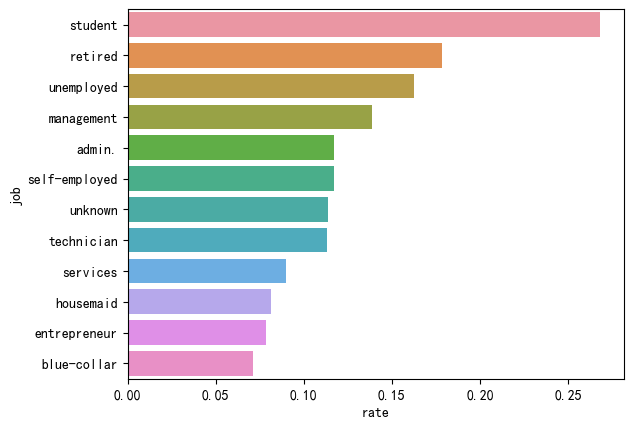

In [225]:
orderlist = tmp[tmp['coupon_ind'] == 1].sort_values(by = 'rate',ascending = False)['job'].tolist()
sns.barplot(y='job',x = 'rate',data = tmp[tmp1['coupon_ind'] == 1],order = orderlist)

在所有职业中，blue-collar的用户数量最多，其次是management,technician,admin,services
在使用优惠券的用户中，management的用户最多，其次是,technician
在使用率方面，学生群体是最高的，其次是退休、无业以及管理人员。

不同婚姻状态的用户使用优惠券的情况

In [137]:
pdd['marital'].value_counts()

married     15035
single       7148
divorced     2850
Name: marital, dtype: int64

<AxesSubplot: xlabel='marital', ylabel='count'>

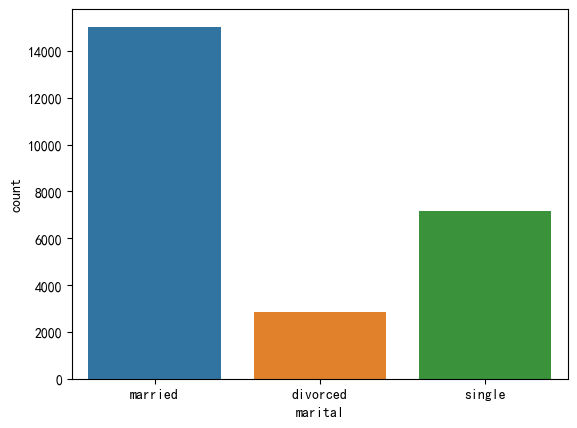

In [139]:
sns.countplot(x = 'marital',data = pdd)

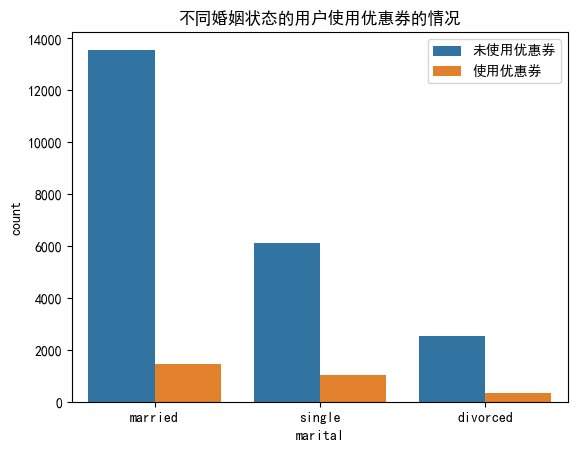

In [147]:
sns.countplot(x='marital',hue = 'coupon_ind',data = pdd,order = pdd['marital'].value_counts().sort_values(ascending=False).index)
plt.title('不同婚姻状态的用户使用优惠券的情况')
plt.legend(['未使用优惠券','使用优惠券'])

In [169]:
tmp = pd.DataFrame(pdd.groupby('marital')['coupon_ind'].value_counts(1)).rename(columns = {'coupon_ind':'rate'}).reset_index()
tmp
tmp[tmp['coupon_ind'] == 1].sort_values(by = 'rate',ascending = False)['marital'].tolist()

['single', 'divorced', 'married']

Text(0.5, 1.0, '不同婚姻状态用户的优惠券使用率')

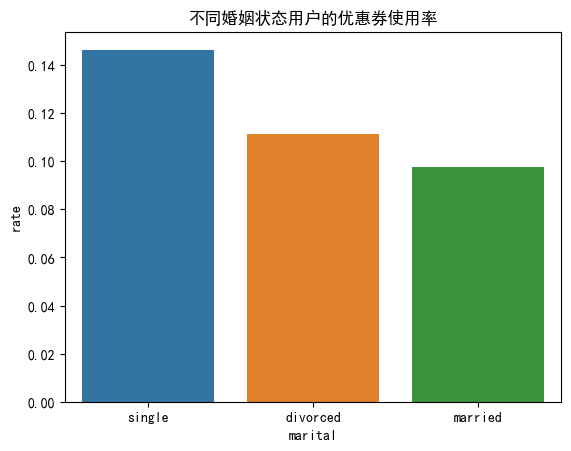

In [173]:
order_list = tmp[tmp['coupon_ind'] == 1].sort_values(by = 'rate',ascending = False)['marital'].tolist()
sns.barplot(x='marital',y='rate',data = tmp[tmp['coupon_ind']==1],order = order_list)
plt.title('不同婚姻状态用户的优惠券使用率')

在所有用户中，单身用户的优惠券使用率最高

信用卡是否违约的用户优惠券使用情况

In [174]:
pdd['default'].value_counts()

no     24586
yes      447
Name: default, dtype: int64

<AxesSubplot: xlabel='default', ylabel='count'>

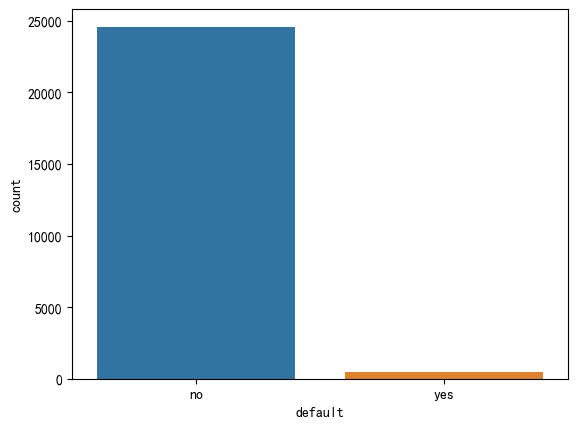

In [177]:
sns.countplot(x='default',data=pdd,order = pdd['default'].value_counts().sort_values(ascending=False).index)


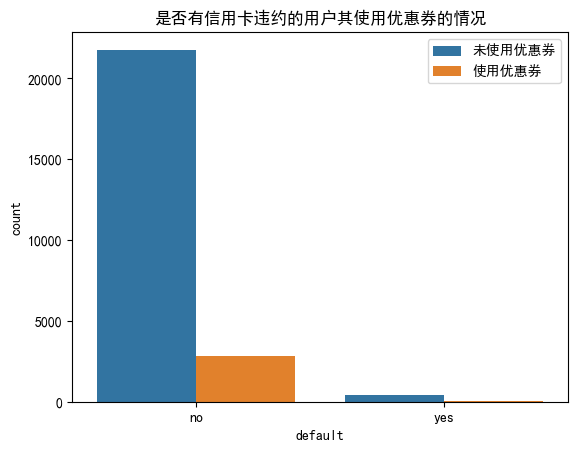

In [179]:
sns.countplot(x='default',hue='coupon_ind',data=pdd,order=pdd['default'].value_counts().sort_values(ascending=False).index)
plt.title('是否有信用卡违约的用户其使用优惠券的情况')
plt.legend(['未使用优惠券','使用优惠券'])

In [192]:
tmp = pd.DataFrame(pdd.groupby('default')['coupon_ind'].value_counts(1)).rename(columns={'coupon_ind':'rate'}).reset_index()
tmp[tmp['coupon_ind']==1].sort_values(by='rate',ascending=False)

,default,coupon_ind,rate
1,no,1,0.114130
3,yes,1,0.055928


<AxesSubplot: xlabel='default', ylabel='rate'>

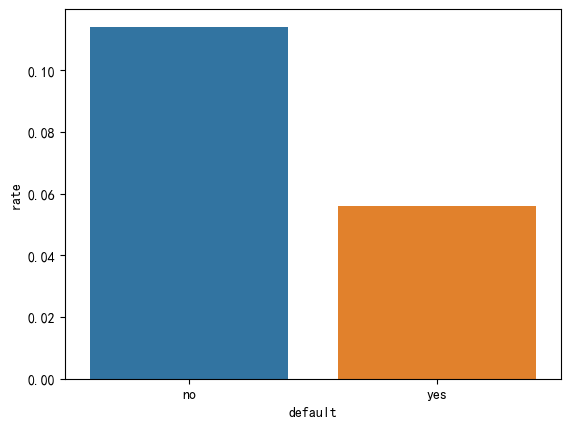

In [198]:
sns.barplot(x='default',y='rate',data=tmp[tmp['coupon_ind']==1].sort_values(by='rate',ascending=False))

只有少数信用卡违约，没有违约的优惠券使用率为11.4%

是否退货的用户优惠券使用情况

In [200]:
pdd['returned'].value_counts()

yes    14014
no     11019
Name: returned, dtype: int64

Text(0.5, 1.0, '是否退货的用户数量')

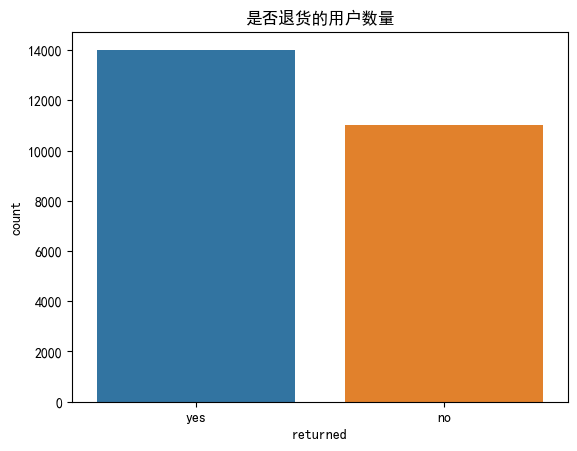

In [203]:
sns.countplot(x='returned',data=pdd)
plt.title('是否退货的用户数量')

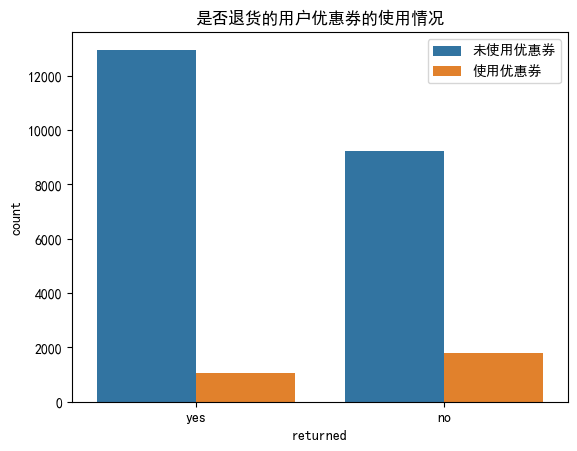

In [204]:
sns.countplot(x='returned',hue = 'coupon_ind',data=pdd)
plt.title('是否退货的用户优惠券的使用情况')
plt.legend(['未使用优惠券','使用优惠券'])

In [226]:
tmp = pd.DataFrame(pdd.groupby('returned')['coupon_ind'].value_counts(1)).rename(columns = {'coupon_ind':'rate'}).reset_index()
tmp[tmp['coupon_ind'] == 1]

,returned,coupon_ind,rate
1,no,1,0.161358
3,yes,1,0.075139


Text(0.5, 1.0, '是否退货的用户优惠券使用率')

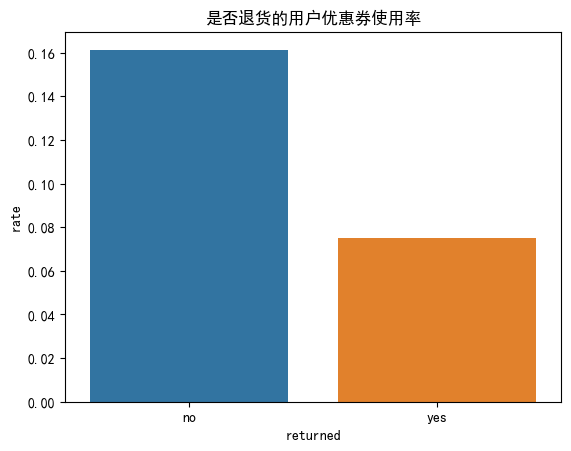

In [218]:
sns.barplot(x = 'returned',y='rate',data =tmp[tmp['coupon_ind'] == 1] )
plt.title('是否退货的用户优惠券使用率')

未退货的用户使用优惠券的比率比退货的用户要高

是否使用信用卡付款的用户优惠券使用情况

In [227]:
pdd['loan'].value_counts()

no     20976
yes     4057
Name: loan, dtype: int64

Text(0.5, 1.0, '是否使用信用卡付款的用户数量')

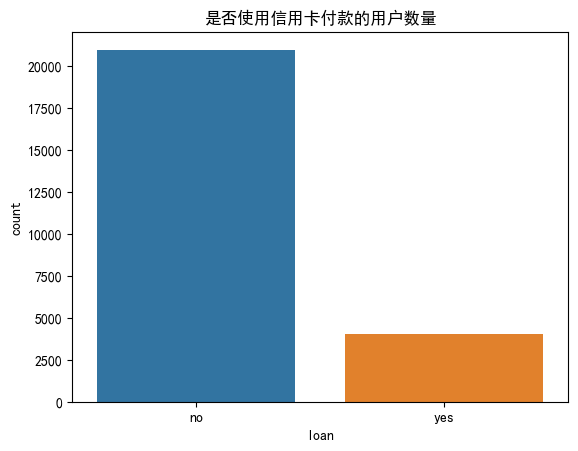

In [229]:
sns.countplot(x='loan',data=pdd)
plt.title('是否使用信用卡付款的用户数量')

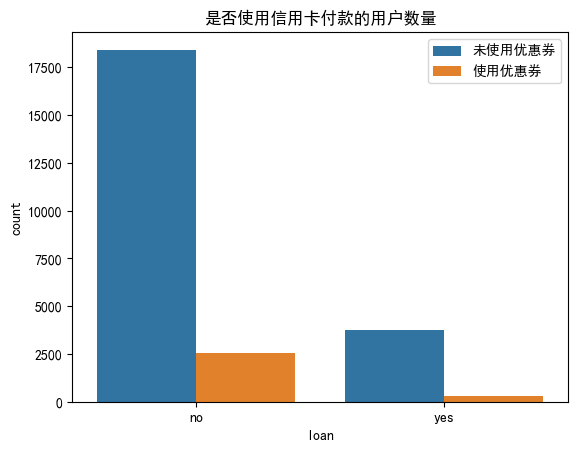

In [231]:
sns.countplot(x='loan',hue= 'coupon_ind',data=pdd)
plt.title('是否使用信用卡付款的用户数量')
plt.legend(['未使用优惠券','使用优惠券'])

In [238]:
tmp = pd.DataFrame(pdd.groupby('loan')['coupon_ind'].value_counts(1)).rename(columns={'coupon_ind':'rate'}).reset_index()
tmp[tmp['coupon_ind'] == 1].sort_values(by='rate',ascending=False)

,loan,coupon_ind,rate
1,no,1,0.121663
3,yes,1,0.068770


Text(0.5, 1.0, '是否使用信用卡付款的用户优惠券使用率')

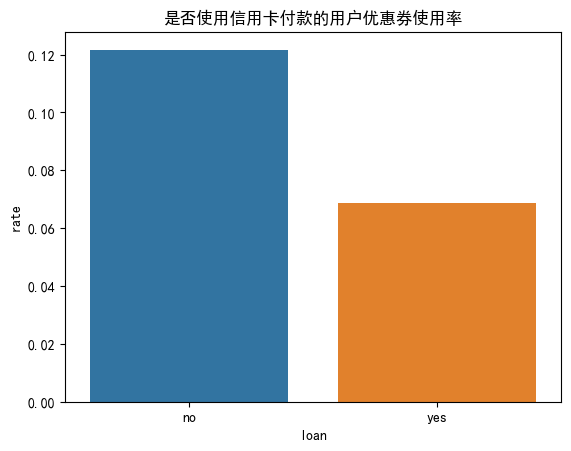

In [242]:
order_list = tmp[tmp['coupon_ind'] == 1].sort_values(by='rate',ascending=False)['loan'].tolist()
sns.barplot(x = 'loan',y='rate',data=tmp[tmp['coupon_ind'] == 1],order = order_list)
plt.title('是否使用信用卡付款的用户优惠券使用率')

不使用信用卡付款的用户优惠券使用率比使用信用卡支付的用户优惠券使用率高

总结：

使用拼多多APP的用户年龄主要在在20-70之间
小于35岁和大于60岁的用户更倾向于使用优惠券
在35~60岁间的用户更倾向于不使用优惠券
小于35岁的用户更倾向于使用优惠券的原因是比较好理解的，因为年轻用户对APP的使用更为熟悉，更容易掌握优惠券的用法，而大于60岁的用户由于数量比较少，是否能直接得出他们更倾向于使用优惠券这一结论有待商榷
而35岁到60岁之间的用户随着年龄增长用户量也随之减少，不倾向于使用优惠券的原因可能是不清楚APP推出的优惠券活动，或者是因为经济能力比较好而无需费心使用优惠券。

在所有职业中，蓝领用户最多，其次是管理人员, 技术人员, 行政人员, 服务行业人员
使用了优惠券的用户中，管理人员最多，其次是技术人员, 蓝领用户, 行政人员, 服务行业人员
但是在各个职业群体中，优惠券使用率最高的是学生、退休人员、无业、管理人员、行政人员

在所有用户中，已婚用户数量最多
单身用户的优惠券使用率最高（14.6%）
只有少数用户信用卡违约
没有信用卡违约的用户的优惠券使用率为11.4%

业务建议：

持续关注年轻人（小于35岁）和老年人（大于60岁）用户的使用优惠券情况，保持这部分群体的优惠券使用率
低收入群体，包括学生、老人、无业人员往往更倾向于使用优惠券，可以向这部分人投放更多优惠券
老年人、单身用户、不使用信用卡付款、没有过退货行为的用户比他们相反群体的用户的优惠券使用概率要高，可以向这部分人投放更多优惠券
中高收入群体是APP的主要使用群体，要想办法提高他们的优惠券使用率